### Dependencies

In [1]:
from utillity_script_cloud_segmentation import *

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
hold_out_set = pd.read_csv('../input/clouds-data-split/hold-out.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')

X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Validation samples: ', len(X_val))
print('Test samples:', len(submission))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(submission.head())

Compete set samples: 22184
Validation samples:  1105
Test samples: 14792


,Image_Label,EncodedPixels,image
0,002f507.jpg_Fish,1 1,002f507.jpg
1,002f507.jpg_Flower,1 1,002f507.jpg
2,002f507.jpg_Gravel,1 1,002f507.jpg
3,002f507.jpg_Sugar,1 1,002f507.jpg
4,0035ae9.jpg_Fish,1 1,0035ae9.jpg


# Model parameters

In [3]:
BACKBONE = 'efficientnetb3'
CLASS_HEIGHT = 224
CLASS_WIDTH = 224
SEG_HEIGHT = 320
SEG_WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
TTA_STEPS = 8
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
best_tresholds_class = [0.75, 0.80, 0.76, 0.73] # beta 0.25
best_tresholds_class2 = [0.64, 0.52, 0.61, 0.59] # beta 0.5
best_tresholds_seg = [0.3, 0.8, 0.4, 0.35]
best_masks_seg = [22500, 20000, 17500, 7500]

classification_model_path = '../input/cloud-seg-modelstoevaluate/19-EfficientNetB0_224x224_Cyclical_triangular.h5'
segmentation_model_path = '../input/70-unet-efficientnetb3-onecycle-decoder-bn-warmup/70-unet_efficientnetb3_320x480.h5'
train_images_path = '../input/cloud-images-resized-320x480/train_images320x480/train_images/'
test_images_path = '../input/cloud-images-resized-320x480/test_images320x480/test_images/'

In [4]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [5]:
classification_model = load_model(classification_model_path)
segmentation_model = load_model(segmentation_model_path, custom_objects={'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

# Segmentation threshold and mask size tunning

In [6]:
mask_grid = [0, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]
threshold_grid = np.arange(.3, 1, .05)
best_tresholds_seg, best_masks_seg = segmentation_tunning(segmentation_model, train, X_val, train_images_path, (SEG_HEIGHT, SEG_WIDTH), label_columns, mask_grid, threshold_grid, N_CLASSES, preprocessing, seed, batch_size=500)

Fish treshold=0.30 mask size=25000 Dice=0.638
Flower treshold=0.85 mask size=15000 Dice=0.776
Gravel treshold=0.50 mask size=17500 Dice=0.633
Sugar treshold=0.35 mask size=7500 Dice=0.616


### Classification data generator

In [7]:
test_datagen=ImageDataGenerator(rescale=1./255.,
                                vertical_flip=True,
                                horizontal_flip=True,
                                zoom_range=[1, 1.2],
                                fill_mode='constant',
                                cval=0.)

classification_test_generator=test_datagen.flow_from_dataframe(
                                            dataframe=test,
                                            directory=test_images_path,
                                            x_col="image",
                                            target_size=(CLASS_HEIGHT, CLASS_WIDTH),
                                            class_mode=None,
                                            batch_size=1,
                                            shuffle=False,
                                            seed=seed)

Found 3698 validated image filenames.


# Apply segmentation model to test set

In [8]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(SEG_HEIGHT, SEG_WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks[..., class_index]
            pred_mask = post_process(pred_mask, threshold=.5, min_size=0)
            pred_masks[...,class_index] = pred_mask

        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        test_df.append(image_df)

X_test = pd.concat(test_df)

# Using TTA Wrapper

In [9]:
segmentation_model_tta = tta_segmentation(segmentation_model, h_flip=True, v_flip=True, merge='mean')
segmentation_model_tta.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, None, None, 3)        0         
_________________________________________________________________
repeat_1 (Repeat)            (4, None, None, 3)        0         
_________________________________________________________________
tta_1 (TTA)                  (4, None, None, 3)        0         
_________________________________________________________________
model_1 (Model)              multiple                  17868268  
_________________________________________________________________
tta_2 (TTA)                  (4, None, None, 4)        0         
_________________________________________________________________
merge_1 (Merge)              (1, None, None, 4)        0         
Total params: 17,868,268
Trainable params: 17,778,988
Non-trainable params: 89,280
__________________________________________

# Apply segmentation model to test set (TTA)

In [10]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(SEG_HEIGHT, SEG_WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model_tta.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks[..., class_index]
            pred_mask = post_process(pred_mask, threshold=.5, min_size=0)
            pred_masks[...,class_index] = pred_mask

        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels_tta'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post_tta'] = pred_rles_post
        
        test_df.append(image_df)

X_test_tta = pd.concat(test_df)

# Apply classifcation model to test set

In [11]:
test_class_preds = apply_tta(classification_model, classification_test_generator, steps=TTA_STEPS)
test_class_preds2 = np.copy(test_class_preds)

for index in range(len(label_columns)):
  test_class_preds[:,index] = (test_class_preds[:,index] > best_tresholds_class[index]).astype(int)
  test_class_preds2[:,index] = (test_class_preds2[:,index] > best_tresholds_class2[index]).astype(int)
  
X_test['empty_mask'] = test_class_preds.reshape(test_class_preds.shape[0]*N_CLASSES)
X_test['empty_mask2'] = test_class_preds2.reshape(test_class_preds2.shape[0]*N_CLASSES)
X_test_tta['empty_mask'] = test_class_preds.reshape(test_class_preds.shape[0]*N_CLASSES)
X_test_tta['empty_mask2'] = test_class_preds2.reshape(test_class_preds2.shape[0]*N_CLASSES)

X_test['EncodedPixels_post_class'] = X_test.apply(lambda row: row['EncodedPixels_post'] if row['empty_mask'] == 0 else '', axis=1)
X_test['EncodedPixels_post2_class'] = X_test.apply(lambda row: row['EncodedPixels_post'] if row['empty_mask2'] == 0 else '', axis=1)
X_test_tta['EncodedPixels_post_tta_class'] = X_test_tta.apply(lambda row: row['EncodedPixels_post_tta'] if row['empty_mask'] == 0 else '', axis=1)
X_test_tta['EncodedPixels_post2_tta_class'] = X_test_tta.apply(lambda row: row['EncodedPixels_post_tta'] if row['empty_mask2'] == 0 else '', axis=1)

### Number of masks removed

In [12]:
print('Masks removed in "%s": %s' % ('EncodedPixels_post_class', len(X_test[(X_test['EncodedPixels_post'] != '') & (X_test['empty_mask'] == 1)])))
print('Masks removed in "%s": %s' % ('EncodedPixels_post2_class', len(X_test[(X_test['EncodedPixels_post'] != '') & (X_test['empty_mask2'] == 1)])))
  
print('Using TTA wrapper')
print('Masks removed in "%s": %s' % ('EncodedPixels_post_tta_class', len(X_test_tta[(X_test_tta['EncodedPixels_post_tta'] != '') & (X_test_tta['empty_mask'] == 1)])))
print('Masks removed in "%s": %s' % ('EncodedPixels_post2_tta_class', len(X_test_tta[(X_test_tta['EncodedPixels_post_tta'] != '') & (X_test_tta['empty_mask2'] == 1)])))

Masks removed in "EncodedPixels_post_class": 25
Masks removed in "EncodedPixels_post2_class": 196
Using TTA wrapper
Masks removed in "EncodedPixels_post_tta_class": 22
Masks removed in "EncodedPixels_post2_tta_class": 168


## Inspecting some of the test set predictions

### Without post-process

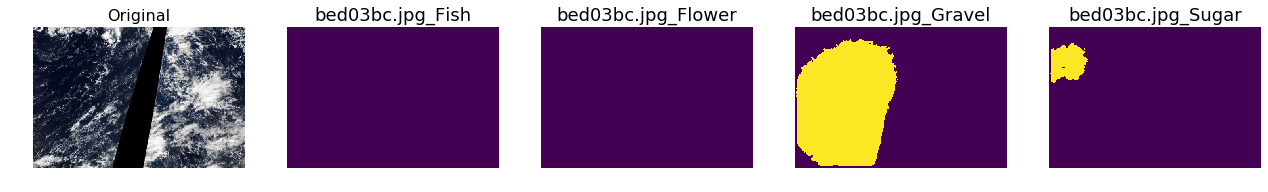

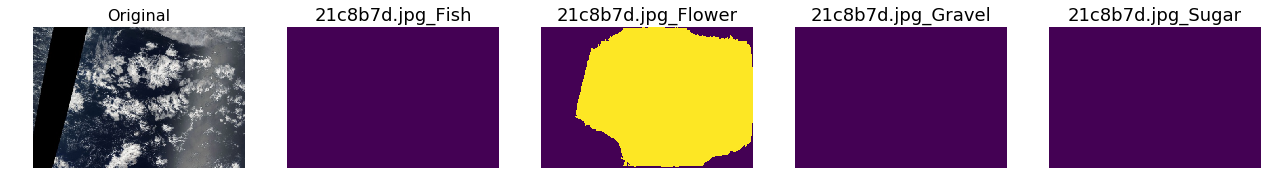

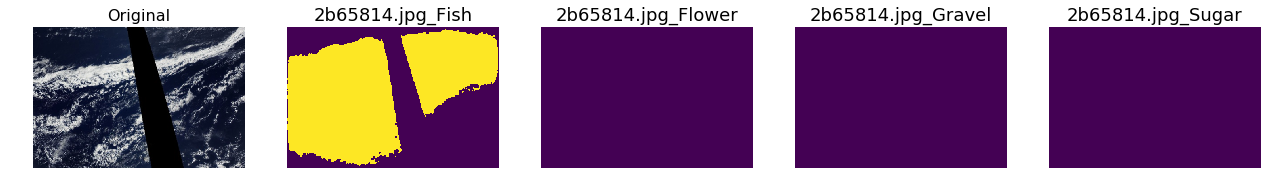

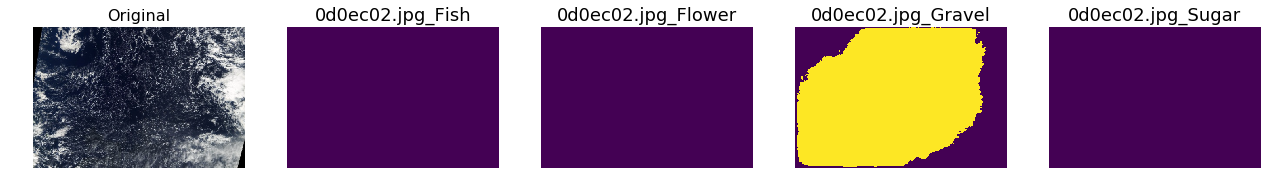

In [13]:
images_to_inspect_test =  np.random.choice(X_test['image'].unique(), 4)
inspect_predictions(X_test, images_to_inspect_test, test_images_path)

### With post-process

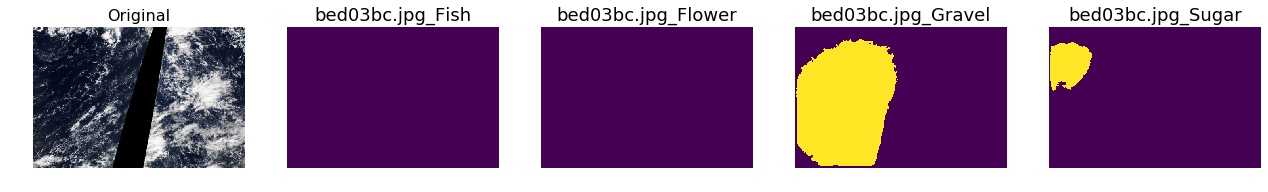

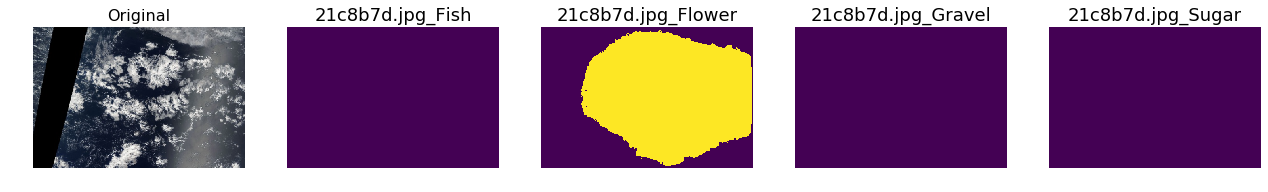

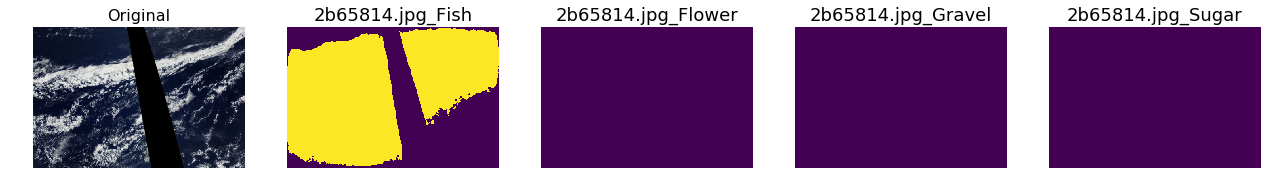

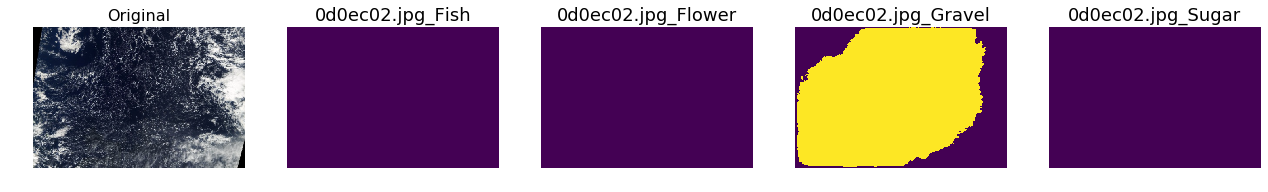

In [14]:
inspect_predictions(X_test, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post')

### Without post-process and TTA

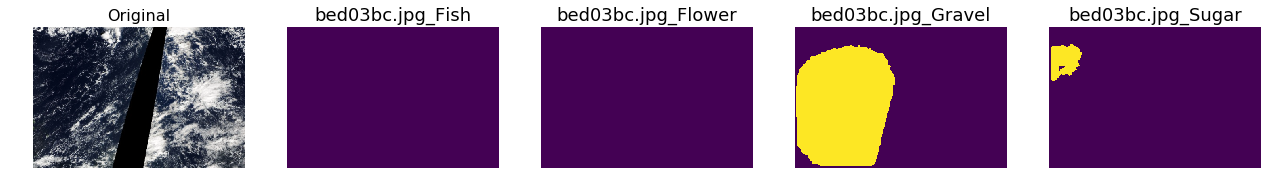

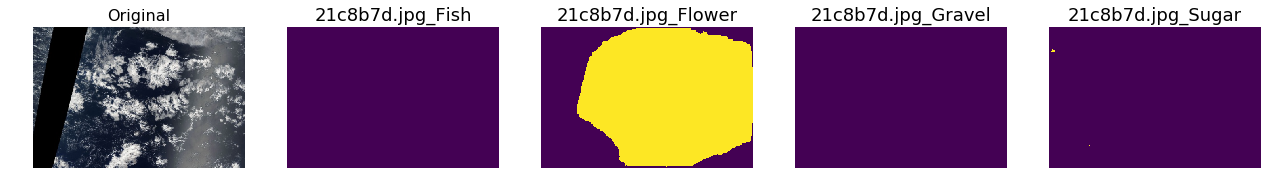

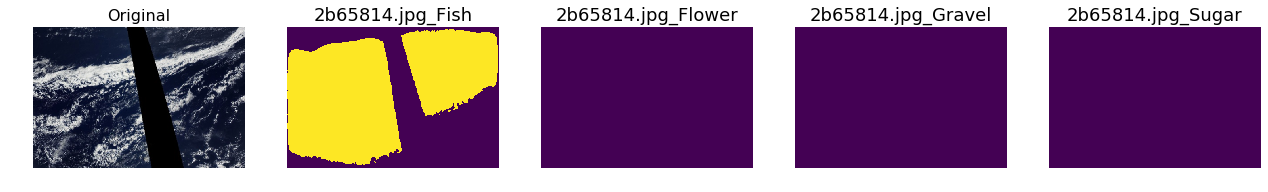

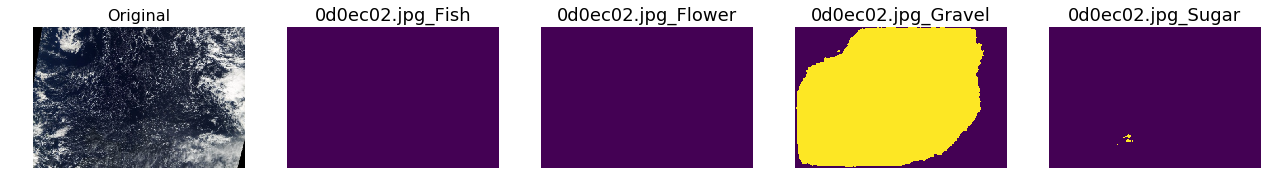

In [15]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_tta')

### With post-process and TTA

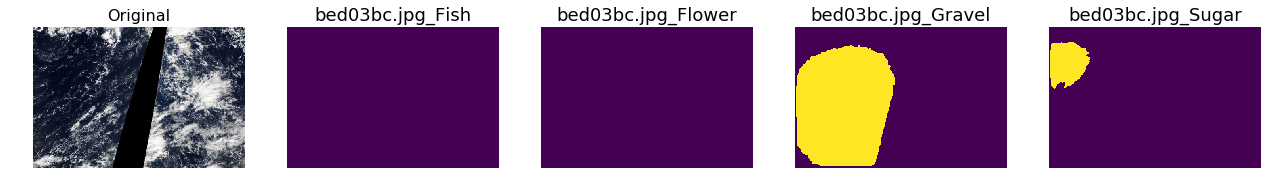

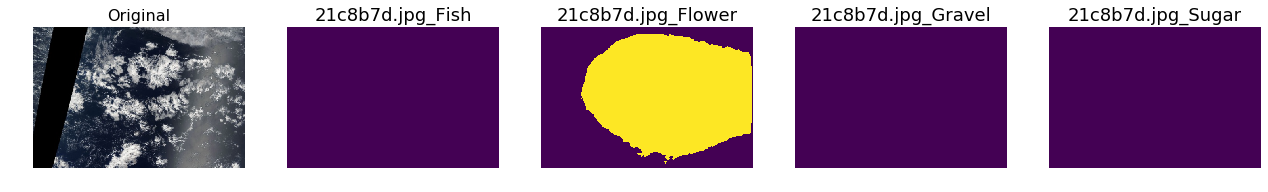

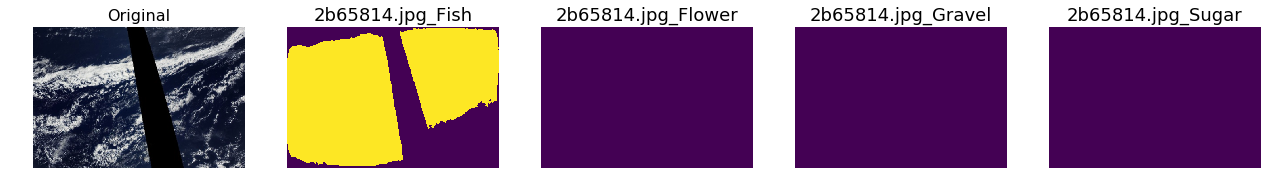

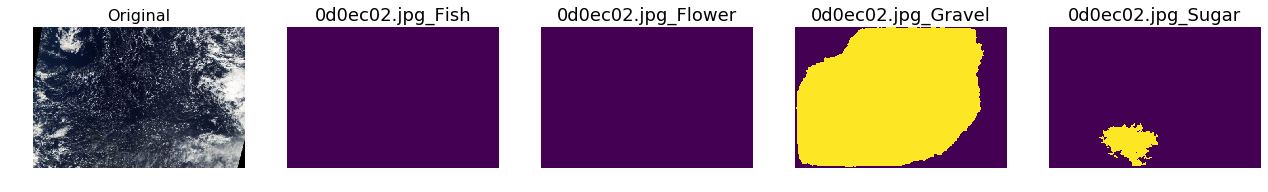

In [16]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_tta')

### Submission with post processing

In [17]:
submission_df = X_test[['Image_Label' ,'EncodedPixels_post']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,1115 2 1139 41 1184 11 1197 1 1200 9 1213 6 12...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing and mask classification (beta 0.25)

In [18]:
submission_df = X_test[['Image_Label' ,'EncodedPixels_post_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post_class.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,1115 2 1139 41 1184 11 1197 1 1200 9 1213 6 12...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing and mask classification (beta 0.5)

In [19]:
submission_df = X_test[['Image_Label' ,'EncodedPixels_post2_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post2_class.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,1115 2 1139 41 1184 11 1197 1 1200 9 1213 6 12...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing and TTA

In [20]:
submission_df = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post_tta.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,785 2 790 37 834 4 1078 202 1311 14 1357 10 14...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing, mask classification (beta 0.25) and TTA

In [21]:
submission_df = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post_tta.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,785 2 790 37 834 4 1078 202 1311 14 1357 10 14...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing, mask classification (beta 0.5) and TTA

In [22]:
submission_df = X_test_tta[['Image_Label' ,'EncodedPixels_post2_tta_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post2_tta.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,785 2 790 37 834 4 1078 202 1311 14 1357 10 14...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,
